In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import numpy as np
import scipy.stats as sts

## World Bank API Call and Data Cleaning

In [2]:
#Define list of indicators you want to loop through
indicator_list = list(["NY.GDP.PCAP.CD","NY.GDP.MKTP.KD.ZG","SL.UEM.TOTL.MA.NE.ZS","SL.UEM.TOTL.FE.NE.ZS"])

#Define country that I'm interested in
country= "usa"

#Find base url for api
base_url = "http://api.worldbank.org/v2"

#Choose desired format
response_format = "json"

#create empty list to store the response
api_responses = []

for indicator in indicator_list:
    
    #Build api request 
    request_url = f"{base_url}/country/{country}/indicator/{indicator}?format={response_format}"

    #Submit api request and store as response variable
    response = requests.get(request_url).json()
    
    #Add each response 
    api_responses = api_responses + response[1]


In [3]:
api_responses[0]["indicator"]["value"]

'GDP per capita (current US$)'

In [4]:
indicator_list = []
country_list = []
year_list = []
value_list = []

for dictionary in api_responses:
    
    indicator = dictionary["indicator"]["value"]
    country = dictionary["country"]["value"]
    year = dictionary["date"]
    value = dictionary["value"]
    
    indicator_list.append(indicator)
    country_list.append(country)
    year_list.append(year)
    value_list.append(value)
    

    

In [5]:
usa_indicator_dict = {
    "indicator":indicator_list,
    "country":country_list,
    "year":year_list,
    "value":value_list
}

In [6]:
df = pd.DataFrame(usa_indicator_dict)

In [7]:
indicator_list = list(df["indicator"].unique())
indicator_list

['GDP per capita (current US$)',
 'GDP growth (annual %)',
 'Unemployment, male (% of male labor force) (national estimate)',
 'Unemployment, female (% of female labor force) (national estimate)']

In [8]:
df_list = []

for indicator in indicator_list:
    
    sub_df = df.loc[df["indicator"]==indicator]
    
    df_list.append(sub_df)

In [9]:
gdp_per_cap = pd.DataFrame(df_list[0])
gdp_growth = pd.DataFrame(df_list[1])
unemployment_male = pd.DataFrame(df_list[2])
unemployment_female = pd.DataFrame(df_list[3])


In [10]:
gdp_per_cap.dropna(inplace=True)
gdp_growth.dropna(inplace=True)
unemployment_male.dropna(inplace=True)
unemployment_female.dropna(inplace=True)

In [11]:
df_list = [gdp_per_cap,gdp_growth,unemployment_male,unemployment_female]
clean_df_list = []

for df in df_list:
    
    indicator = df.iloc[0,0]
    
    df = df[["country","year","value"]]
    
    df.columns = ["country","year",indicator]
    
    clean_df_list.append(df)

In [12]:
regression_df = pd.merge(clean_df_list[0],clean_df_list[1], on = ["country","year"])
regression_df = pd.merge(regression_df, clean_df_list[2], on = ["country","year"])
regression_df = pd.merge(regression_df, clean_df_list[3], on = ["country","year"])

In [13]:
regression_df.columns = ["country","year","gdp_per_cap","gdp_growth","unemployment_male","unemployment_female"]

In [14]:
MCslope, MCintercept, MCr, MCp_value, MCstdev = sts.linregress(regression_df["unemployment_male"],regression_df["gdp_per_cap"])
FCslope, FCintercept, FCr, FCp_value, FCstdev = sts.linregress(regression_df["unemployment_female"],regression_df["gdp_per_cap"])

In [15]:
regression_df["male_unemployment_best_fit_per_cap"] = MCslope*regression_df["unemployment_male"] + MCintercept

In [16]:
regression_df["female_unemployment_best_fit_per_cap"] = FCslope*regression_df["unemployment_female"] + FCintercept

In [17]:
MGslope, MGintercept, MGr, MGp_value, MGstdev = sts.linregress(regression_df["unemployment_male"],regression_df["gdp_growth"])
FGslope, FGintercept, FGr, FGp_value, FGstdev = sts.linregress(regression_df["unemployment_female"],regression_df["gdp_growth"])

In [18]:
regression_df["male_unemployment_best_fit_growth"] = MGslope*regression_df["unemployment_male"] + MGintercept

In [19]:
regression_df["female_unemployment_best_fit_growth"] = FGslope*regression_df["unemployment_female"] + FGintercept

In [20]:
regression_df.head()

,country,year,gdp_per_cap,gdp_growth,unemployment_male,unemployment_female,male_unemployment_best_fit_per_cap,female_unemployment_best_fit_per_cap,male_unemployment_best_fit_growth,female_unemployment_best_fit_growth
0,United States,2018,62794.585652,2.927323,3.9468,3.8377,30434.291828,43345.097441,3.564230,3.254315
1,United States,2017,59927.929834,2.217010,4.3964,4.3086,30314.062258,40818.565109,3.402721,3.159945
2,United States,2016,57904.201961,1.567215,4.9397,4.7888,30168.775900,38242.136559,3.207552,3.063712
3,United States,2015,56803.472433,2.880910,5.3692,5.1785,30053.921330,36151.266799,3.053262,2.985615
4,United States,2014,55032.957998,2.451973,6.2620,6.0603,29815.173672,31420.123946,2.732543,2.808899


## Regression GDP Per Capita v. Unemployment Male

The correlation coefficient for this relationship is -0.03


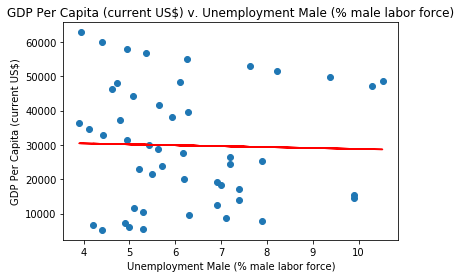

In [21]:
plt.scatter(regression_df["unemployment_male"],regression_df["gdp_per_cap"])
plt.plot(regression_df["unemployment_male"],regression_df["male_unemployment_best_fit_per_cap"], c="red")
plt.title("GDP Per Capita (current US$) v. Unemployment Male (% male labor force)")
plt.xlabel("Unemployment Male (% male labor force)")
plt.ylabel("GDP Per Capita (current US$)")

print(f"The correlation coefficient for this relationship is {round(MCr,2)}")


The correlation coefficient for this relationship is -0.46


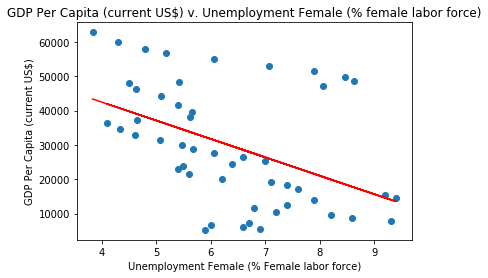

In [22]:
plt.scatter(regression_df["unemployment_female"],regression_df["gdp_per_cap"])
plt.plot(regression_df["unemployment_female"],regression_df["female_unemployment_best_fit_per_cap"], c="red")
plt.title("GDP Per Capita (current US$) v. Unemployment Female (% female labor force)")
plt.xlabel("Unemployment Female (% Female labor force)")
plt.ylabel("GDP Per Capita (current US$)")

print(f"The correlation coefficient for this relationship is {round(FCr,2)}")

The correlation coefficient for this relationship is -0.31


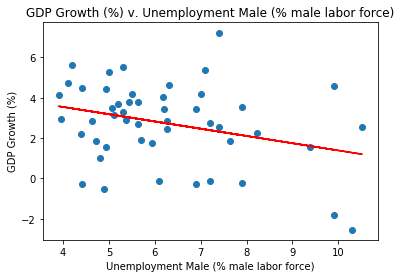

In [23]:
plt.scatter(regression_df["unemployment_male"],regression_df["gdp_growth"])
plt.plot(regression_df["unemployment_male"],regression_df["male_unemployment_best_fit_growth"], c="red")
plt.title("GDP Growth (%) v. Unemployment Male (% male labor force)")
plt.xlabel("Unemployment Male (% male labor force)")
plt.ylabel("GDP Growth (%)")

print(f"The correlation coefficient for this relationship is {round(MGr,2)}")


The correlation coefficient for this relationship is -0.15


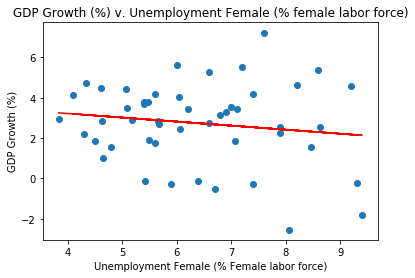

In [24]:
plt.scatter(regression_df["unemployment_female"],regression_df["gdp_growth"])
plt.plot(regression_df["unemployment_female"],regression_df["female_unemployment_best_fit_growth"], c="red")
plt.title("GDP Growth (%) v. Unemployment Female (% female labor force)")
plt.xlabel("Unemployment Female (% Female labor force)")
plt.ylabel("GDP Growth (%)")

print(f"The correlation coefficient for this relationship is {round(FGr,2)}")